## HW 6
Botasheva Zhanna

## Что день грядущий нам готовит? Построение прогноза временного ряда с использованием изученных методов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, \
    median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# подгружаем данные
data = pd.read_csv('C:/Users/Zhanna Botasheva/Desktop/Курс ML/Professional/28 Анализ временных рядов. Часть 2 Извлечение признаков и применение моделей машинного обучения. Автоматическое прогнозирование/Metro_Interstate_Traffic_Volume.csv.gz')
data.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### 1.EDA

Оставим 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха).

In [4]:
data = data.drop(['rain_1h', 'snow_1h','clouds_all', 'weather_main', 'weather_description'], axis=1)

In [5]:
data

holiday    temp            date_time  traffic_volume
0         NaN  288.28  2012-10-02 09:00:00            5545
1         NaN  289.36  2012-10-02 10:00:00            4516
2         NaN  289.58  2012-10-02 11:00:00            4767
3         NaN  290.13  2012-10-02 12:00:00            5026
4         NaN  291.14  2012-10-02 13:00:00            4918
...       ...     ...                  ...             ...
48199     NaN  283.45  2018-09-30 19:00:00            3543
48200     NaN  282.76  2018-09-30 20:00:00            2781
48201     NaN  282.73  2018-09-30 21:00:00            2159
48202     NaN  282.09  2018-09-30 22:00:00            1450
48203     NaN  282.12  2018-09-30 23:00:00             954

[48204 rows x 4 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [7]:
data.describe()

temp  traffic_volume
count  48204.000000    48204.000000
mean     281.205870     3259.818355
std       13.338232     1986.860670
min        0.000000        0.000000
25%      272.160000     1193.000000
50%      282.450000     3380.000000
75%      291.806000     4933.000000
max      310.070000     7280.000000

In [8]:
data['holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [9]:
data['temp'].unique()

array([288.28, 289.36, 289.58, ..., 306.08, 304.41, 304.9 ])

Конверитируем колонку date_time в datetime и устанавливаем её как индекс

In [10]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [11]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

Проверим и удалим дубликаты

In [12]:
data.duplicated().sum()

7551

In [13]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [14]:
data.shape

(40653, 4)

Проверим есть ли пропущенные значения и заменим их

In [15]:
data.isna().sum()

holiday           40600
temp                  0
date_time             0
traffic_volume        0
dtype: int64

In [16]:
data['holiday'].fillna('None', inplace=True)
data.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

In [17]:
def plot_data(data):
    data.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.show()

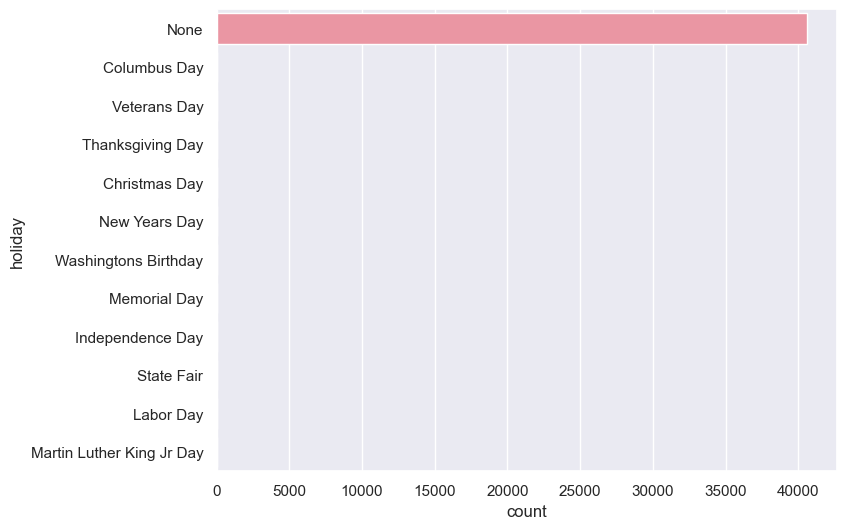

In [18]:
#Построение графика частоты каждой категории в столбце 'holiday'
plt.figure(figsize = (8,6))
sns.countplot(y='holiday', data = data)
plt.show()

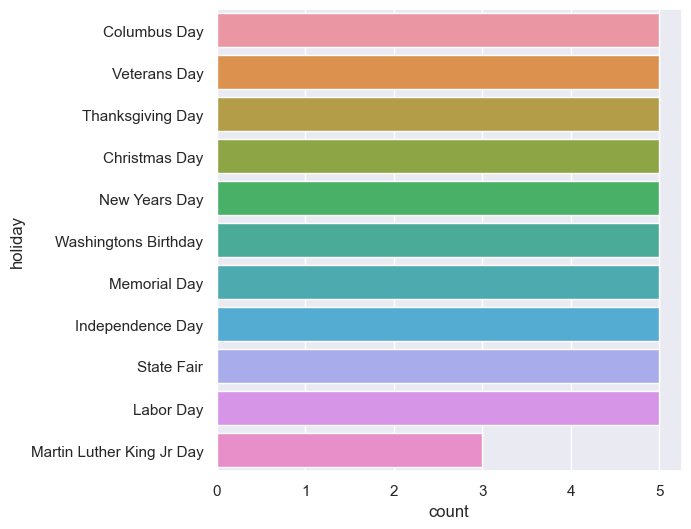

In [19]:
holidays = data.loc[data.holiday != 'None']
plt.figure(figsize=(6,6))
sns.countplot(y='holiday', data= holidays)
plt.show()

In [20]:
#Переведем температуру в Кельвинах в Цельсии
#(0K − 273.15)
data['temp'] = (data['temp']-273.15)
data

holiday   temp           date_time  traffic_volume
date_time                                                             
2012-10-02 09:00:00    None  15.13 2012-10-02 09:00:00            5545
2012-10-02 10:00:00    None  16.21 2012-10-02 10:00:00            4516
2012-10-02 11:00:00    None  16.43 2012-10-02 11:00:00            4767
2012-10-02 12:00:00    None  16.98 2012-10-02 12:00:00            5026
2012-10-02 13:00:00    None  17.99 2012-10-02 13:00:00            4918
...                     ...    ...                 ...             ...
2018-09-30 19:00:00    None  10.30 2018-09-30 19:00:00            3543
2018-09-30 20:00:00    None   9.61 2018-09-30 20:00:00            2781
2018-09-30 21:00:00    None   9.58 2018-09-30 21:00:00            2159
2018-09-30 22:00:00    None   8.94 2018-09-30 22:00:00            1450
2018-09-30 23:00:00    None   8.97 2018-09-30 23:00:00             954

[40653 rows x 4 columns]

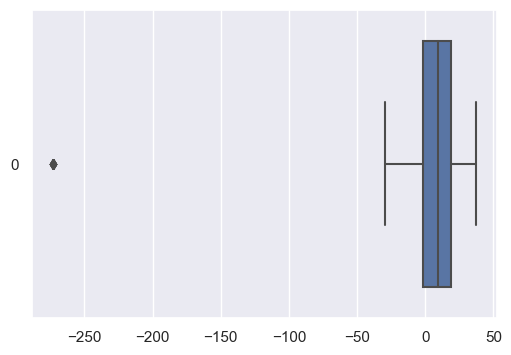

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(data.temp, orient="h")
plt.show()

Одна точка данных удалена от остальных примерно на -280 градусов по Цельсию. Очевидно, что это ошибка записи. Удалим ее.


In [22]:
data = data[data.temp>-250]

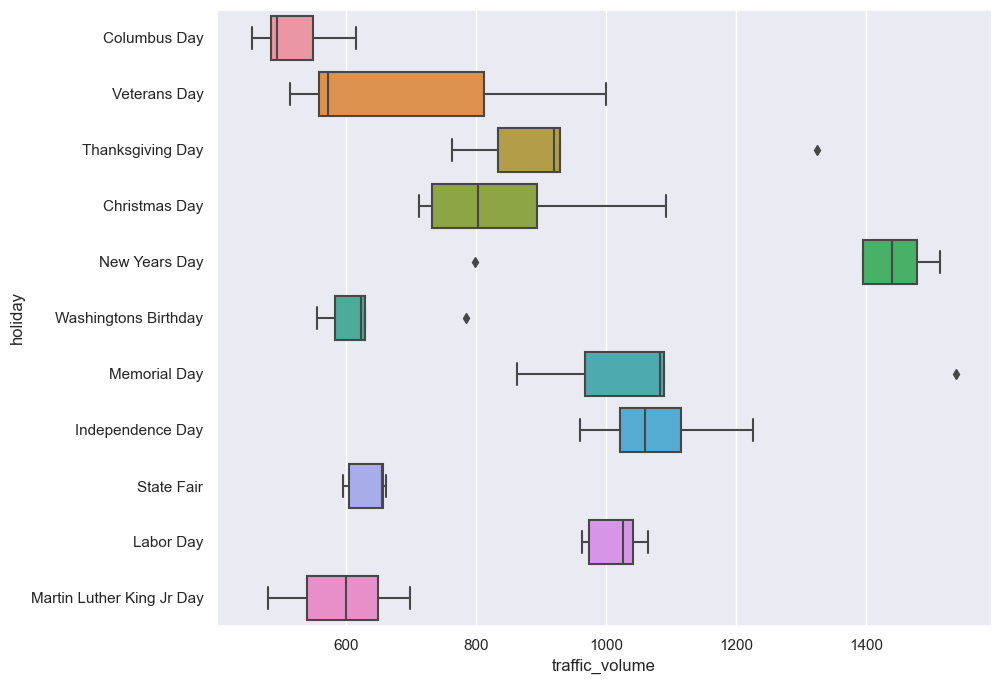

In [23]:
#Посмотрим загруженность в праздничные дни
plt.figure(figsize=(10,8))
sns.boxplot(y='holiday',x='traffic_volume', data = holidays)
plt.show()

Проверим временной промежуток

In [24]:
len(data['date_time'])

40643

In [25]:
len(data['date_time'].unique())

40565

In [26]:
pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')

Реальный временной промежуток равен length=52551, поработаем на пропускми.

In [27]:
df = pd.DataFrame({'real_date_time': pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')})

In [28]:
df['date_time'] =  pd.to_datetime(df['real_date_time'], format='%Y-%m-%d %H:%M:%S')

In [29]:
# Сделаем индексы
df = df.set_index(pd.DatetimeIndex(df['date_time']))

In [30]:
df.head()

real_date_time           date_time
date_time                                                  
2012-10-02 09:00:00 2012-10-02 09:00:00 2012-10-02 09:00:00
2012-10-02 10:00:00 2012-10-02 10:00:00 2012-10-02 10:00:00
2012-10-02 11:00:00 2012-10-02 11:00:00 2012-10-02 11:00:00
2012-10-02 12:00:00 2012-10-02 12:00:00 2012-10-02 12:00:00
2012-10-02 13:00:00 2012-10-02 13:00:00 2012-10-02 13:00:00

In [31]:
df = df.drop(columns=['date_time'], axis=1)


In [32]:
len(df)

52551

In [33]:
df_new = df.merge(data, how='left', left_on='real_date_time', right_index=True)

In [34]:
df_new = df_new.set_index('date_time')
len(df_new)

52629

In [35]:
df_new.head()

real_date_time holiday   temp  traffic_volume
date_time                                                             
2012-10-02 09:00:00 2012-10-02 09:00:00    None  15.13          5545.0
2012-10-02 10:00:00 2012-10-02 10:00:00    None  16.21          4516.0
2012-10-02 11:00:00 2012-10-02 11:00:00    None  16.43          4767.0
2012-10-02 12:00:00 2012-10-02 12:00:00    None  16.98          5026.0
2012-10-02 13:00:00 2012-10-02 13:00:00    None  17.99          4918.0

In [36]:
df_new = df_new.drop(columns=['real_date_time'], axis=1)

In [37]:
df = df_new.interpolate(method='linear')
df.head(3)

holiday   temp  traffic_volume
date_time                                         
2012-10-02 09:00:00    None  15.13          5545.0
2012-10-02 10:00:00    None  16.21          4516.0
2012-10-02 11:00:00    None  16.43          4767.0

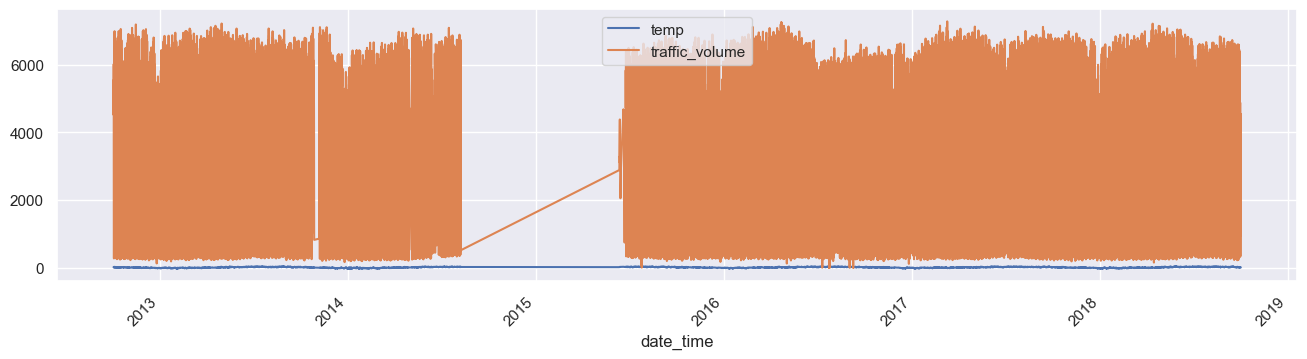

In [38]:
plot_data(df_new)

### 2.Моделирование

Возьмем данные за последний год

In [39]:
df_new = df_new['2017-10-01':'2018-09-30']
df_new .head()

holiday   temp  traffic_volume
date_time                                         
2017-10-01 00:00:00    None  15.78          1447.0
2017-10-01 01:00:00    None  15.40           894.0
2017-10-01 02:00:00    None  15.29           617.0
2017-10-01 03:00:00    None  15.14           426.0
2017-10-01 04:00:00    None  14.50           356.0

In [40]:
df_new.shape

(8733, 3)

Отложим последние две недели из датасета для тестов

In [41]:
split_date = '2018-09-16'
df_train = df_new.iloc[df_new.index < split_date].copy()
df_test = df_new.iloc[df_new.index > split_date].copy()

In [42]:
(df_train.shape, df_test.shape)

((8373, 3), (359, 3))

In [43]:
def plot_data(df):
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

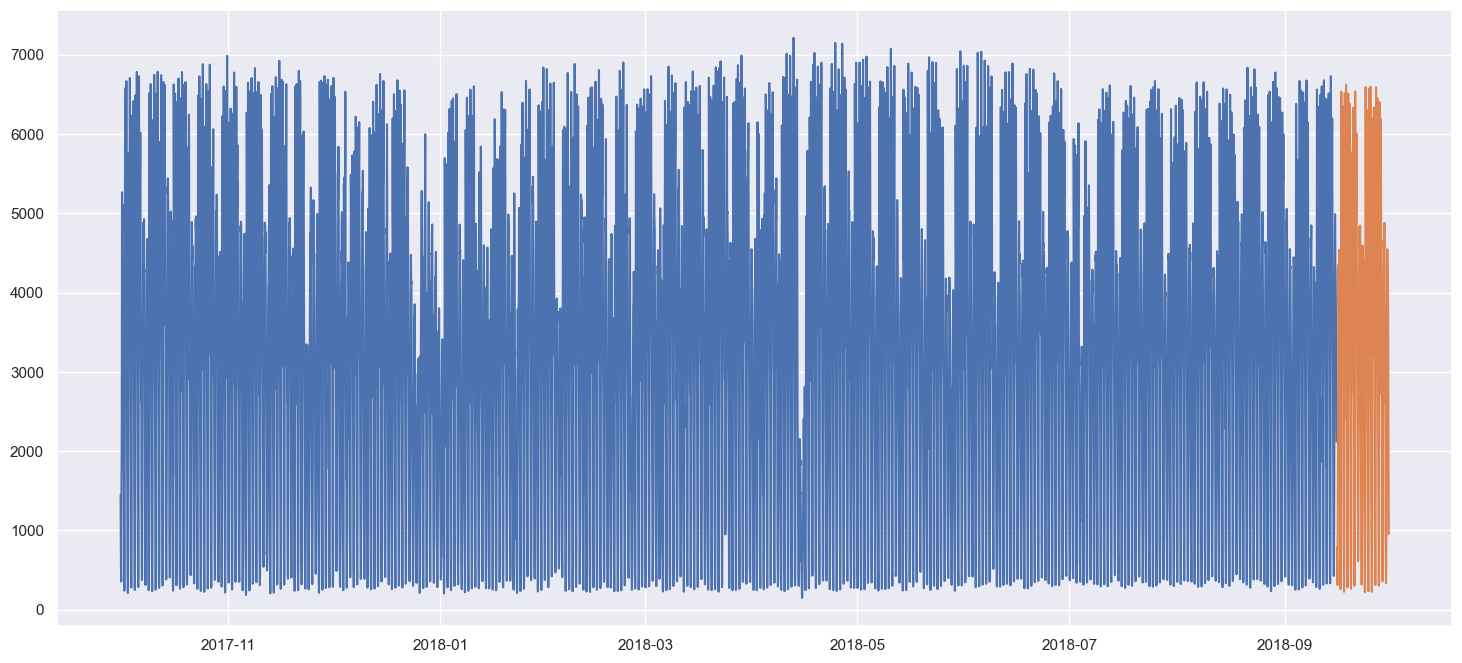

In [44]:
plot_data(df_new)

Генерируем дополнительные признаки

In [45]:
def create_features(df, label=None):
    """
    Генерируем дополнительные признаки из datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year']]
    
    if label:
        y = df[label]
        return X, y
    return X

Метрики

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute Percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

Строим baseline

In [48]:
new_features_train = create_features(df_train)
df_groupby_train = df_train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()
new_features_test = create_features(df_test)
df_groupby_test = df_test.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [49]:
error_metrics(df_groupby_train, df_groupby_test)

Mean Absolute Error: 172.61
Root Mean Squared Error: 245.26
Mean Absolute Percentage Error: 6.78 %


In [50]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [51]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8373, 8), (359, 8), (8373,), (359,))

LinearRegression

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [53]:
def plot_predictions(y_pred):
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

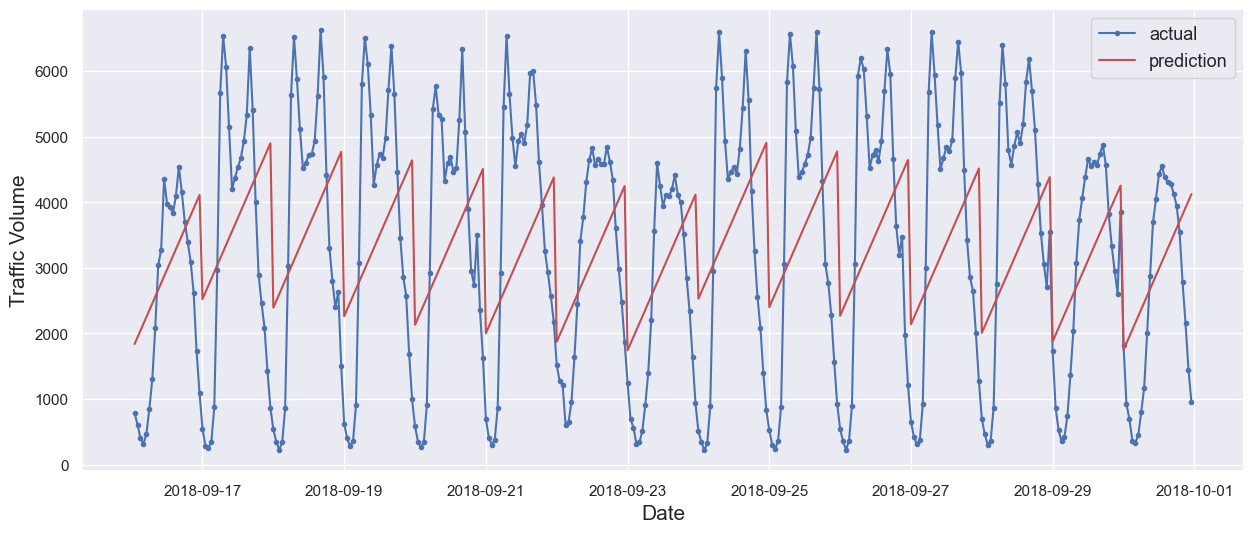

In [54]:
plot_predictions(y_pred)

In [55]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1578.56
Root Mean Squared Error: 1795.92
Mean Absolute Percentage Error: 132.36 %


GradientBoostingRegressor

In [56]:
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

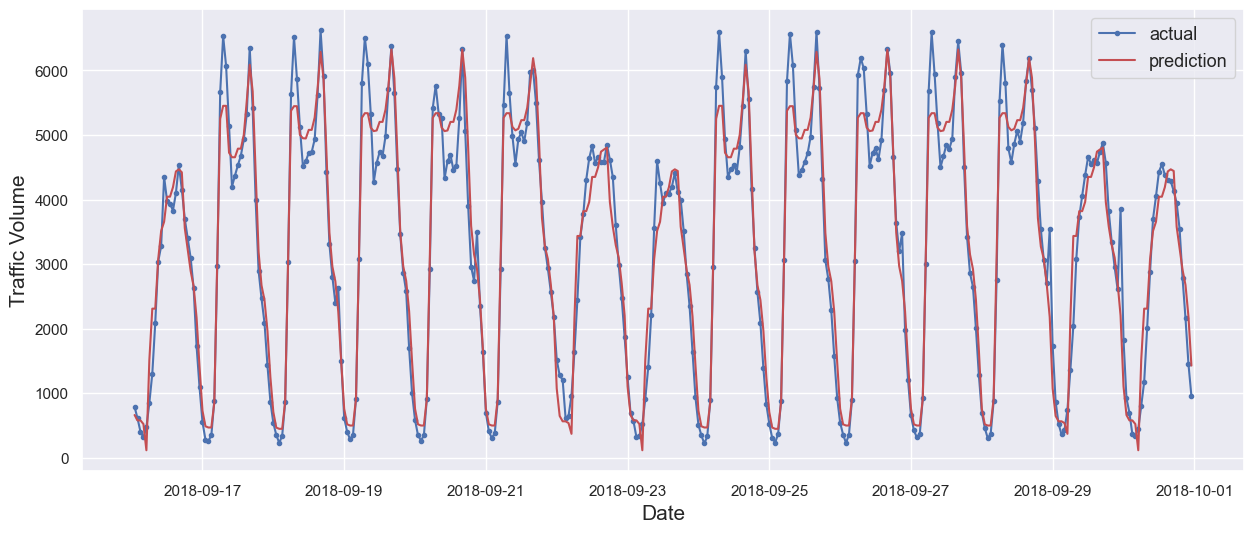

In [57]:
plot_predictions(y_pred)

In [58]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 316.45
Root Mean Squared Error: 417.69
Mean Absolute Percentage Error: 17.47 %


Prophet

In [59]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df_new.index)
df_fbp["y"] = df_new['traffic_volume'].values

In [60]:
df_fbp.head()

ds       y
0 2017-10-01 00:00:00  1447.0
1 2017-10-01 01:00:00   894.0
2 2017-10-01 02:00:00   617.0
3 2017-10-01 03:00:00   426.0
4 2017-10-01 04:00:00   356.0

In [61]:
fb_y_train = df_fbp.iloc[:-359].copy()
fb_y_test = df_fbp.iloc[-359:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [62]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
forecast.tail(2)

ds        trend  yhat_lower   yhat_upper  trend_lower  \
357 2018-09-30 22:00:00  3369.164511  616.016298  2853.782376  3363.261818   
358 2018-09-30 23:00:00  3369.176298  332.010372  2534.353733  3363.227027   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
357  3375.886203    -1620.958734          -1620.958734          -1620.958734   
358  3375.945182    -1961.853128          -1961.853128          -1961.853128   

           daily  daily_lower  daily_upper      weekly  weekly_lower  \
357 -1218.149030 -1218.149030 -1218.149030 -402.809704   -402.809704   
358 -1591.190061 -1591.190061 -1591.190061 -370.663068   -370.663068   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
357   -402.809704                   0.0                         0.0   
358   -370.663068                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
357                         0.0  1748.205777  
358                         0.0  1407.323170

In [64]:
forecast_pred = forecast['yhat'].copy().astype(np.float32)
forecast_test = fb_y_test['y'].copy().astype(np.float32)
error_metrics(forecast_test, forecast_pred)

Mean Absolute Error: 612.34
Root Mean Squared Error: 820.15
Mean Absolute Percentage Error: nan %


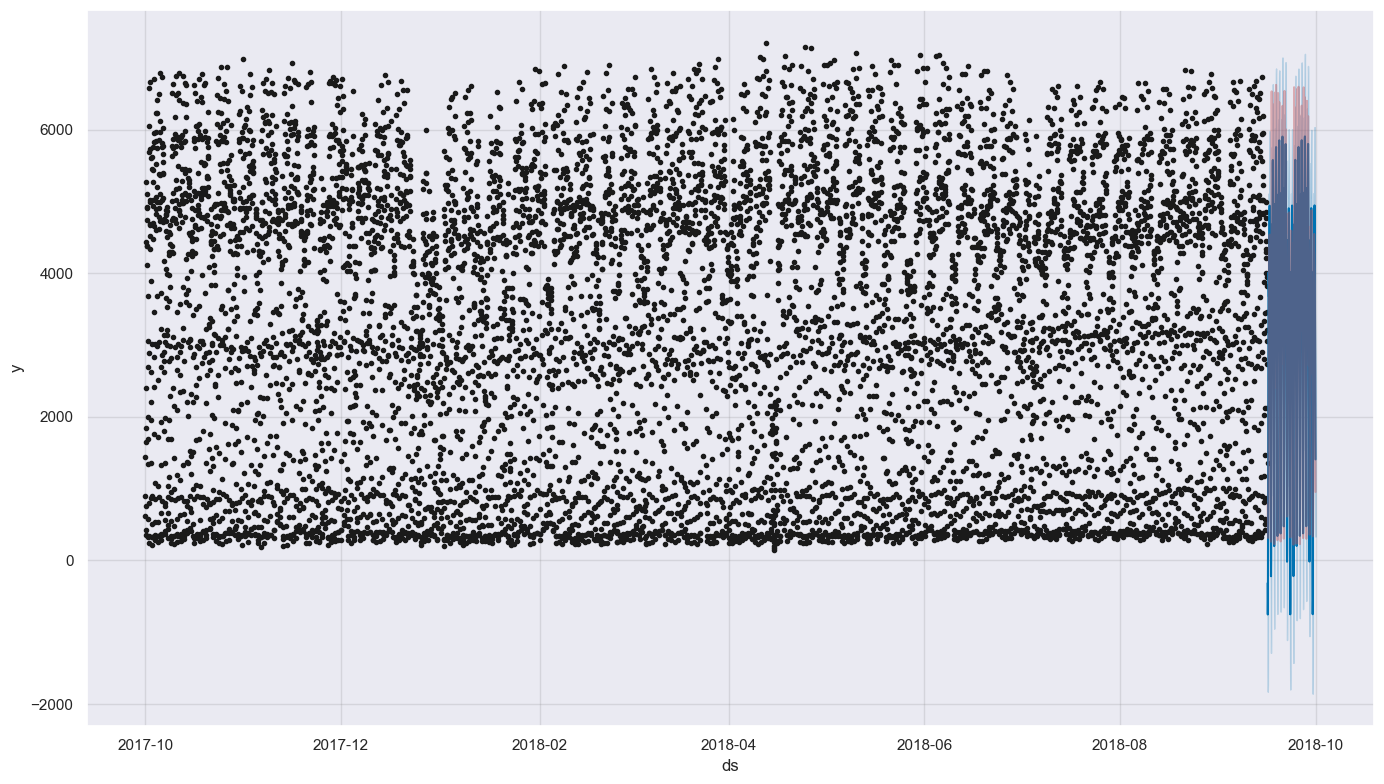

In [65]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [66]:
plot_plotly(fbmodel, forecast)

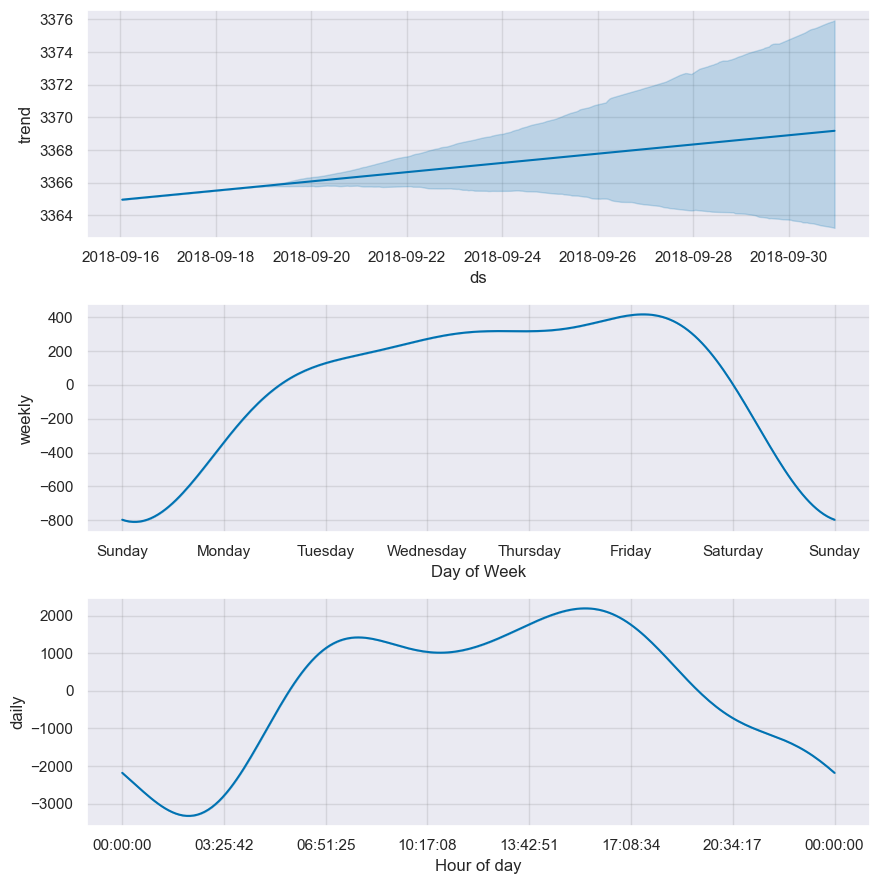

In [67]:
_ = fbmodel.plot_components(forecast)

ARIMA

In [68]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
     
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df.traffic_volume)

(0.01, False)

In [69]:
df_arima = pd.DataFrame()
df_arima["ds"] = pd.to_datetime(df_new.index)
df_arima["y"] = df_new['traffic_volume'].values

arima_y_train = df_arima.iloc[:-359].copy()
arima_y_test = df_arima.iloc[-359:].copy()
arima_y_val = arima_y_test[["ds"]].copy()
     

arima_y_train = arima_y_train.drop(['ds'], axis=1)
arima_y_train

y
0     1447.0
1      894.0
2      617.0
3      426.0
4      356.0
...      ...
8369  3208.0
8370  3055.0
8371  2741.0
8372  2123.0
8373  1353.0

[8374 rows x 1 columns]

In [70]:
arima_model = auto_arima(y_train, m=12,
                        suppress_warnings=True, 
                        stepwise=True,
                        seasonal=True,
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=56.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=150871.207, Time=0.43 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=133788.032, Time=26.99 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=140127.268, Time=21.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=162094.701, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=135681.064, Time=1.32 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=114.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=130458.573, Time=54.76 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=134955.257, Time=6.28 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=128154.085, Time=82.48 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=128178.670, Time=82.04 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=129727.912, Time=90.78 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=139919.672, Time=142.23 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=125986.171, Time=95.

In [71]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 8373
Model:             SARIMAX(3, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood              -62910.087
Date:                                 Tue, 06 Feb 2024   AIC                         125838.174
Time:                                         19:33:36   BIC                         125901.468
Sample:                                              0   HQIC                        125859.789
                                                - 8373                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    371.2708     29.573     12.554      0.000     313.308     429.234
ar.L1          1.3399      0.007    193.641      0.000       1.326       1.353
ar.L2         -0.6025      0.013    -44.884      0.000      -0.629      -0.576
ar.L3          0.0601      0.011      5.617      0.000       0.039       0.081
ar.S.L12      -0.2131      0.020    -10.749      0.000      -0.252      -0.174
ar.S.L24       0.6695      0.018     37.640      0.000       0.635       0.704
ma.S.L12       0.0814      0.024      3.373      0.001       0.034       0.129
ma.S.L24      -0.2151      0.018    -11.802      0.000      -0.251      -0.179
sigma2      1.962e+05   1898.771    103.341      0.000    1.92e+05       2e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):              4494.96
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
prediction = pd.DataFrame(arima_model.predict(n_periods=359))
prediction.columns = ['predicted_traffic_volume']
prediction.head(10)

C:\Users\Zhanna Botasheva\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



predicted_traffic_volume
8373               1499.993252
8374               1320.895602
8375               1266.349692
8376               1168.645654
8377               1267.399424
8378               1850.093764
8379               2614.669171
8380               3193.842095
8381               3799.692753
8382               3979.008737

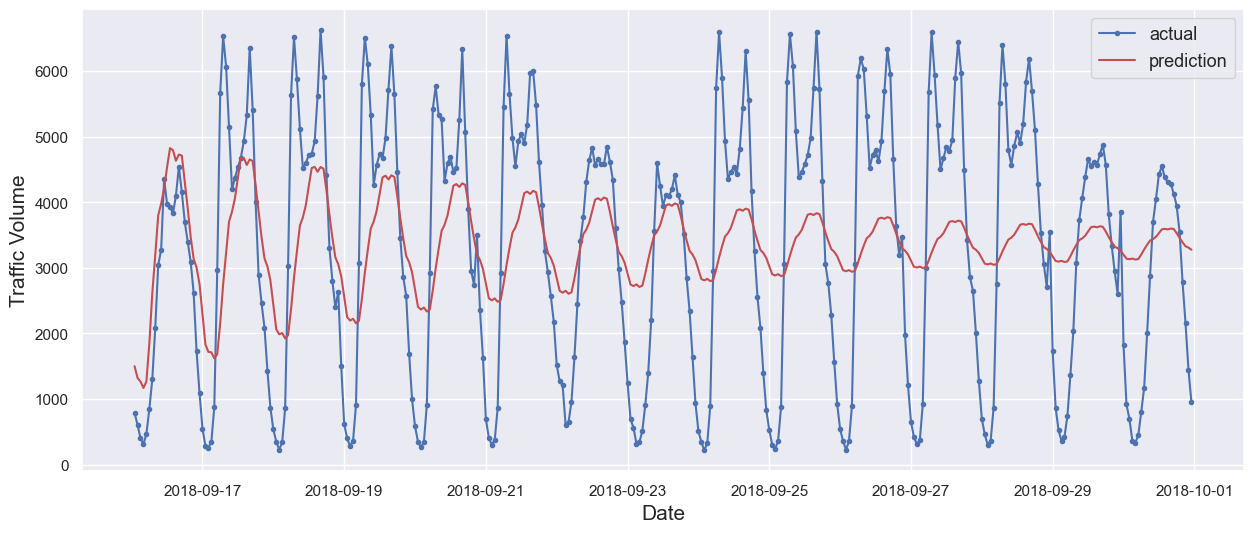

In [73]:
plot_predictions(prediction)

In [74]:
r2_score(y_test, prediction)

0.3097911460918581

In [75]:
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, prediction)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 1353.08
Root Mean Squared Error: 1616.88
